In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import text
from  tensorflow.keras.preprocessing import sequence
import tensorflow_datasets as tfds
import numpy as np
import json
import matplotlib.pyplot as plt

In [ ]:
print(tf.__version__)

2.4.1


In [ ]:
print("# of GPUs:", len(tf.config.experimental.list_physical_devices('GPU')))

# of GPUs: 1


# Tạo dữ liệu

## Download dữ liệu tfds

In [ ]:
?tfds.load

Signature:
tfds.load(
    name,
    split=None,
    data_dir=None,
    batch_size=None,
    in_memory=None,
    shuffle_files=None,
    download=True,
    as_supervised=False,
    decoders=None,
    with_info=False,
    builder_kwargs=None,
    download_and_prepare_kwargs=None,
    as_dataset_kwargs=None,
    try_gcs=False,
)
Docstring:
Loads the named dataset into a `tf.data.Dataset`.

If `split=None` (the default), returns all splits for the dataset. Otherwise,
returns the specified split.

`load` is a convenience method that fetches the `tfds.core.DatasetBuilder` by
string name, optionally calls `DatasetBuilder.download_and_prepare`
(if `download=True`), and then calls `DatasetBuilder.as_dataset`.
This is roughly equivalent to:

```
builder = tfds.builder(name, data_dir=data_dir, **builder_kwargs)
if download:
  builder.download_and_prepare(**download_and_prepare_kwargs)
ds = builder.as_dataset(
    split=split, as_supervised=as_supervised, **as_dataset_kwargs)
if with_info:
  retur

`load` is a convenience method that fetches the `tfds.core.DatasetBuilder` by
string name, optionally calls `DatasetBuilder.download_and_prepare`
(if `download=True`), and then calls `DatasetBuilder.as_dataset`.
This is roughly equivalent to:

```
builder = tfds.builder(name, data_dir=data_dir, **builder_kwargs)
if download:
  builder.download_and_prepare(**download_and_prepare_kwargs)
ds = builder.as_dataset(
    split=split, as_supervised=as_supervised, **as_dataset_kwargs)
if with_info:
  return ds, builder.info
return ds
```

In [ ]:
## Download dữ liệu:
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

In [ ]:
# Kiểm tra loại dữ liệu của imdb:
imdb.__class__

dict

In [ ]:
imdb.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [ ]:
# Tạo tập train, valid:
train_ds, valid_ds = imdb['train'], imdb['test']

In [ ]:
train_ds.__class__

tensorflow.python.data.ops.dataset_ops._OptionsDataset

In [ ]:
# Kiểm tra dữ liệu:
for s, l in train_ds.take(1):
    print(s)
    print(l)

tf.Tensor(b"This was soul-provoking! I am an Iranian, and living in th 21st century, I didn't know that such big tribes have been living in such conditions at the time of my grandfather!<br /><br />You see that today, or even in 1925, on one side of the world a lady or a baby could have everything served for him or her clean and on-demand, but here 80 years ago, people ventured their life to go to somewhere with more grass. It's really interesting that these Persians bear those difficulties to find pasture for their sheep, but they lose many the sheep on their way.<br /><br />I praise the Americans who accompanied this tribe, they were as tough as Bakhtiari people.", shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
# Chuyển đổi dữ liệu sang dạng string:
train_sentences = []
train_labels = []
for s, l in train_ds:
    train_sentences.append(str(s.numpy())) # bổ sung từng câu dưới dạng string vào list
    train_labels.append(l.numpy()) # bổ sung nhãn dưới dạng số vào list
print(f'#{len(train_sentences)}:')
print(train_sentences[0])
print(train_labels[0])
print(f'Số lượng labels: {set(train_labels)}')

#25000:
b'Sitting down to watch the 14th season of the Bachelor ("On the Wings of Love"), I knew I would be in for an "interesting" time. I had watched some of the previous seasons of the Bachelor in passing; watching an episode or two and missing the next three or so. I find that the Bachelor is often appealing and intriguing, though its quality and morality are often lacking.<br /><br />"On the Wings of Love" details the journey taken by Jake, a 31 year old commercial pilot from Dallas, Texas, to find true love, as true a love as one can find in a season-long reality-drama dating show. Jake meets 25 beautiful girls from all over the country. He begins to get to know them a bit, but it is mostly superficial; how well can you get to know someone in a few 5 minute conversations? Jake tries to make his true intentions known from the very beginning, at least to the audience. He noted that he doesn\'t just want love or a good time, but he wants a fianc\xc3\xa9 or wife. We can only assume t

In [ ]:
# Làm tương tự với dữ liệu valid:
valid_sentences = []
valid_labels = []

for s, l in valid_ds:
    valid_sentences.append(str(s.numpy()))
    valid_labels.append(l.numpy())
print(f'#{len(valid_sentences)}:')
print(valid_sentences[0])
print(valid_labels[0])

#25000:
b"I've watched the movie actually several times. And what i want to say about it is the only thing that made this movie high rank was the Burak Altay's incredible performance, absolutely nothing but that. Not even those silly model named Deniz Akkaya and some of these popular names at times in the movie... Burak is definitely very talented i've seen a few jobs he made and been through. Even though this is kind of horror movie, he's doing really good job in comedy movies and also in dramas too. I bet most of you all saw Asmali Konak the movie and TV series, those two would go for an example... All i'm gonna say is you better watch out for the new works coming out from Burak then you'll see.. Keep the good work bro, much love.."
1


__Lưu ý:__
Như vây chúng ta đã có cả dữ liệu về train, valid, với cùng độ dài là 2500 câu. Và nhãn ở dạng binary (0, 1).

## Tokenize

In [ ]:
vocab_size = 10000
embedding_dim = 16
max_len = 120
trunc_type = 'post'
oov_tok = 'UNK'
# Tạo tokenizer và fit dữ liệu train:
tokenizer = text.Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

# Tạo word_index, sequences, pad_sequences từ tập train:
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(train_sentences)
padded_sequences = sequence.pad_sequences(sequences, maxlen=max_len, padding='post', truncating=trunc_type)

# Tạo sequences, pad_sequences từ tập valid:
valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
padded_valid_sequences = sequence.pad_sequences(valid_sequences, maxlen=max_len, padding='post', truncating=trunc_type)

In [ ]:
# Biến đổi dữ liệu:
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)

# Tạo Wordembedding Model

In [ ]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len)
    , keras.layers.Flatten()
    , keras.layers.Dense(6, activation='relu')
    , keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Đào tạo:
model.fit(padded_sequences, train_labels, batch_size=64, epochs=10, validation_data=(padded_valid_sequences, valid_labels))

Epoch 1/10
391/391 [==============================] - 12s 26ms/step - loss: 0.6921 - accuracy: 0.5224 - val_loss: 0.6672 - val_accuracy: 0.6525
Epoch 2/10
391/391 [==============================] - 10s 26ms/step - loss: 0.5916 - accuracy: 0.7441 - val_loss: 0.4307 - val_accuracy: 0.8125
Epoch 3/10
391/391 [==============================] - 10s 26ms/step - loss: 0.3475 - accuracy: 0.8613 - val_loss: 0.3809 - val_accuracy: 0.8296
Epoch 4/10
391/391 [==============================] - 11s 27ms/step - loss: 0.2670 - accuracy: 0.8992 - val_loss: 0.3727 - val_accuracy: 0.8323
Epoch 5/10
391/391 [==============================] - 10s 27ms/step - loss: 0.2103 - accuracy: 0.9291 - val_loss: 0.3763 - val_accuracy: 0.8330
Epoch 6/10
391/391 [==============================] - 10s 25ms/step - loss: 0.1697 - accuracy: 0.9487 - val_loss: 0.3927 - val_accuracy: 0.8280
Epoch 7/10
391/391 [==============================] - 10s 25ms/step - loss: 0.1316 - accuracy: 0.9644 - val_loss: 0.4100 - val_accuracy:

## Kiểm tra kết quả

In [ ]:
history = model.history

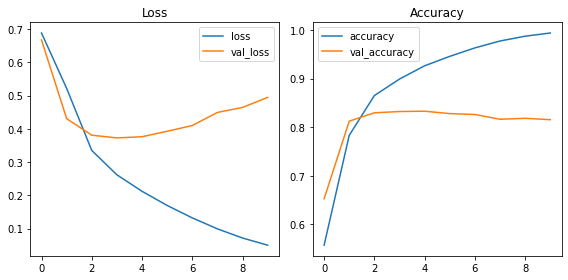

In [ ]:
figure = plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['loss', 'val_loss'])
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy')
plt.tight_layout()

Chúng ta có thể thấy, chỉ sau khoảng 4 epoch thì cả loss và accuracy của tập valid có dấu hiệu giảm về chất lượng (loss tăng, accuracy giảm).

# Sarcasm Dataset

In [ ]:
sentences = []
labels = []
urls = []

file_name = '/home/ddpham/git/TFExam/data/Sarcasm_Headlines_Dataset.json'
file = open(file_name, 'r')
for line in file.readlines():
    line = json.loads(line)
    sentences.append(line['headline'])
    labels.append(line['is_sarcastic'])
    urls.append(line['article_link'])
file.close()

In [ ]:
print(f'#{len(sentences)}:\n{sentences[0]}, \n{labels[0]}, \n{urls[0]}')

#26709:
former versace store clerk sues over secret 'black code' for minority shoppers, 
0, 
https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5


## Tokenization

In [ ]:
num_words = 10000
embed_dim = 16
# max_len=20
trunc_type='post'
padding_type='post'
oov_token = 'UNK'
training_size = 20000

In [ ]:
train_sentences = sentences[:training_size]
valid_sentences = sentences[training_size:]
train_labels = np.array(labels[:training_size])
valid_labels = np.array(labels[training_size:])

In [ ]:
tokenizer = text.Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
train_sentences = tokenizer.texts_to_sequences(train_sentences)
valid_sentences = tokenizer.texts_to_sequences(valid_sentences)

In [ ]:
# Chúng ta hay kiểm tra một chút về độ dài của tất cả các câu:
len_sentences = []
for i in train_sentences:
    len_sentences.append(len(i))
len_dict = dict.fromkeys(set(len_sentences), 0)
for length in len_sentences:
    len_dict[length] += 1
len_dict

{2: 85,
 3: 228,
 4: 380,
 5: 777,
 6: 1218,
 7: 1640,
 8: 2048,
 9: 2406,
 10: 2569,
 11: 2470,
 12: 2082,
 13: 1457,
 14: 1027,
 15: 638,
 16: 397,
 17: 267,
 18: 142,
 19: 63,
 20: 43,
 21: 24,
 22: 18,
 23: 8,
 24: 3,
 26: 2,
 27: 1,
 28: 1,
 29: 1,
 30: 2,
 31: 1,
 39: 1,
 40: 1}

<AxesSubplot:xlabel='len'>

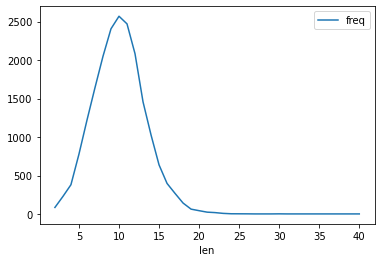

In [ ]:
# Vẽ đồ thị histogram về tần suất độ dài:
import pandas as pd
pd.DataFrame(list(len_dict.items()), columns=['len', 'freq']).plot('len', 'freq')

In [ ]:
# Padding:
train_sentences = sequence.pad_sequences(train_sentences, padding=padding_type, truncating=trunc_type)
valid_sentences = sequence.pad_sequences(valid_sentences, padding=padding_type, truncating=trunc_type)

In [ ]:
train_sentences.shape, valid_sentences.shape

((20000, 40), (6709, 38))

In [ ]:
train_sentences[5:10, 10:15]

array([[  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [150,   6,  33, 343,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0]], dtype=int32)

## Tạo model

In [ ]:
model = keras.Sequential([
    keras.layers.Embedding(num_words, embed_dim, input_length=max_len)
    , keras.layers.GlobalAveragePooling1D()
    , keras.layers.Dense(24, activation='relu')
    , keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 16)            160000    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
n = 30
model.fit(train_sentences, train_labels, epochs=n, validation_data=(valid_sentences, valid_labels), verbose=2)

Epoch 1/30
625/625 - 12s - loss: 0.6325 - accuracy: 0.6349 - val_loss: 0.5199 - val_accuracy: 0.7636
Epoch 2/30
625/625 - 10s - loss: 0.4258 - accuracy: 0.8249 - val_loss: 0.4075 - val_accuracy: 0.8144
Epoch 3/30
625/625 - 11s - loss: 0.3439 - accuracy: 0.8566 - val_loss: 0.3725 - val_accuracy: 0.8384
Epoch 4/30
625/625 - 10s - loss: 0.3059 - accuracy: 0.8732 - val_loss: 0.3622 - val_accuracy: 0.8459
Epoch 5/30
625/625 - 10s - loss: 0.2824 - accuracy: 0.8820 - val_loss: 0.3584 - val_accuracy: 0.8512
Epoch 6/30
625/625 - 11s - loss: 0.2677 - accuracy: 0.8891 - val_loss: 0.3609 - val_accuracy: 0.8489
Epoch 7/30
625/625 - 10s - loss: 0.2565 - accuracy: 0.8944 - val_loss: 0.3645 - val_accuracy: 0.8478
Epoch 8/30
625/625 - 11s - loss: 0.2478 - accuracy: 0.9000 - val_loss: 0.3607 - val_accuracy: 0.8533
Epoch 9/30
625/625 - 11s - loss: 0.2407 - accuracy: 0.9031 - val_loss: 0.3609 - val_accuracy: 0.8529
Epoch 10/30
625/625 - 10s - loss: 0.2360 - accuracy: 0.9049 - val_loss: 0.3659 - val_accura

In [ ]:
history = model.history

In [ ]:
# Chúng ta muốn vẽ kết quả của lần train vừa rồi 
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

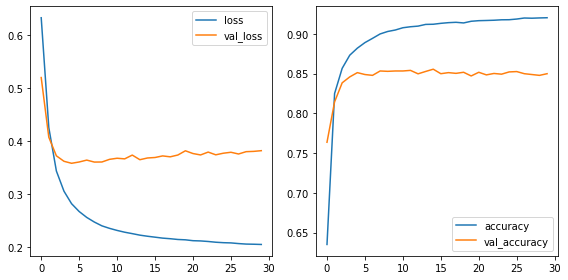

In [ ]:
# Sử dụng loop:
item_dict = {'Loss': ['loss', 'val_loss'], 'Accuracy': ['accuracy', 'val_accuracy']}
plot_list = ['Loss', 'Accuracy']
plt.figure(figsize=(8, 4))
for i in range(len(plot_list)):
    plt.subplot(1, 2, i+1)
    item = plot_list[i]
    for items in item_dict[item]:
        plt.plot(history.history[items])
    plt.legend(item_dict[item])
plt.tight_layout()

In [ ]:
# Tạo hàm plot:
def plot_history(history):
    item_dict = {'Loss': ['loss', 'val_loss'], 'Accuracy': ['accuracy', 'val_accuracy']}
    plot_list = ['Loss', 'Accuracy']
    plt.figure(figsize=(8, 4))
    for i in range(len(plot_list)):
        plt.subplot(1, 2, i+1)
        item = plot_list[i]
        for items in item_dict[item]:
            plt.plot(history.history[items])
        plt.legend(item_dict[item])
    plt.tight_layout()

__Lưu ý:__ 
Chúng ta có thể thấy được kết quả của việc train dữ liệu thông qua việc visualize loss và metric.

Nhìn vào đồ thị, chúng ta có thể thấy, chỉ với dưới 3 epochs, dữ liệu của tập validate đã có dấu hiện bị overfit khi cả giá trị loss và giá trị accuracy đều không có tiến triển.

## Tunning model
> Chúng ta thử thay đổi một vài hyper-parameters để xem kết quả của model có được cải thiện không.

In [ ]:
num_words = 1000 # giảm từ 10K
max_len = 20 # giảm từ 40
embed_dim = 15 # giảm từ 16
trunc_type = 'post'
pad_type = 'post'
oov_token = 'UNK'
training_size = 18000 # tăng size cho tập valid

In [ ]:
# Parse dữ liệu
sentences = []
labels = []
urls = []

file_name = '/home/ddpham/git/TFExam/data/Sarcasm_Headlines_Dataset.json'
file = open(file_name, 'r')
for line in file.readlines():
    line = json.loads(line)
    sentences.append(line['headline'])
    labels.append(line['is_sarcastic'])
    urls.append(line['article_link'])
file.close()

train_sentences = sentences[:training_size]
valid_sentences = sentences[training_size:]
train_labels = labels[:training_size]
valid_labels = labels[training_size:]

In [ ]:
# Tokenize & padding:
tokenizer = text.Tokenizer(num_words=num_words, oov_token=oov_token)
# dir(tokenizer)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(train_sentences)
valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)

train_sequences = sequence.pad_sequences(train_sequences, maxlen=max_len, padding=pad_type, truncating=trunc_type)
valid_sequences = sequence.pad_sequences(valid_sequences, maxlen=max_len, padding=pad_type, truncating=trunc_type)
# Kiểm tra shape:
train_sequences.shape, valid_sequences.shape

((18000, 20), (8709, 20))

### Tạo neural net mới

In [ ]:
model = keras.Sequential([
    keras.layers.Embedding(num_words, embed_dim, input_length=max_len)
    , keras.layers.GlobalAveragePooling1D()
    , keras.layers.Dense(24, activation='relu')
    , keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 20, 15)            15000     
_________________________________________________________________
global_average_pooling1d_6 ( (None, 15)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 24)                384       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 25        
Total params: 15,409
Trainable params: 15,409
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_sequences, train_labels, epochs=10, batch_size=32, validation_data=(valid_sequences, valid_labels))

Epoch 1/10
563/563 [==============================] - 13s 22ms/step - loss: 0.6488 - accuracy: 0.6225 - val_loss: 0.4271 - val_accuracy: 0.8066
Epoch 2/10
563/563 [==============================] - 13s 24ms/step - loss: 0.3964 - accuracy: 0.8215 - val_loss: 0.3953 - val_accuracy: 0.8181
Epoch 3/10
563/563 [==============================] - 13s 23ms/step - loss: 0.3573 - accuracy: 0.8368 - val_loss: 0.3950 - val_accuracy: 0.8135
Epoch 4/10
563/563 [==============================] - 12s 22ms/step - loss: 0.3565 - accuracy: 0.8363 - val_loss: 0.3958 - val_accuracy: 0.8139
Epoch 5/10
563/563 [==============================] - 12s 21ms/step - loss: 0.3488 - accuracy: 0.8429 - val_loss: 0.3987 - val_accuracy: 0.8126
Epoch 6/10
563/563 [==============================] - 12s 21ms/step - loss: 0.3378 - accuracy: 0.8491 - val_loss: 0.3991 - val_accuracy: 0.8154
Epoch 7/10
563/563 [==============================] - 12s 21ms/step - loss: 0.3435 - accuracy: 0.8479 - val_loss: 0.3995 - val_accuracy:

In [ ]:
history = model.history

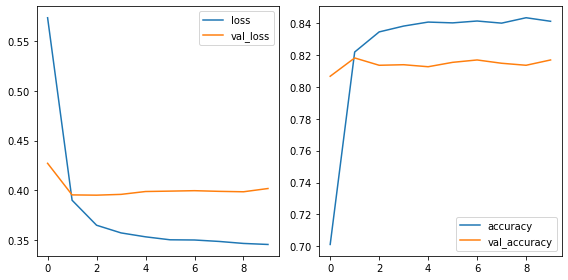

In [ ]:
# Visualize:
plot_history(history)

__NOTE:__
Chúng ta có thể thấy, mặc dù accuracy của valid giảm xuống tương đối (3%), nhưng mức độ overfit của model rõ ràng đã cải thiện đáng kể. Khoảng cách giữa train và valid đã thu hẹp tương đối nhiều (giảm > 2 lần) cho cả loss và accuracy.

Chúng ta có thể thử tiếp vs max_len=15, embed_dim=10 để kiểm tra model có cải thiện về mức độ overfit hay ko. Tất nhiên, khi chúng ta giảm chiều xuống thì sẽ ít hơn số lượng từ tương đồng hoặc đối lập nhau để có thể view được những từ có ý nghĩa hơn và những từ tương đồng hay đối lập thường sẽ rất hiển nhiên.

# Giới thiệu về subword tokenizer
> Khác với tokenizer chúng ta biết ở trên, các từ được gán với id (dạng số nguyên dương) và được hợp thành sequences để đào tạo model. Tuy nhiên, với subword tokenizer, một từ có thể được tách ra nhỏ hơn.
> Phần này tạm thời dừng lại ở đây!